In [ ]:
#hide
# default_exp MRI
from nbdev.showdoc import *

In [ ]:
#export 
from fastai.vision.all import *
import nibabel as nib
import SimpleITK as sitk
import tqdm
# from volumentations import *

做一个列表

In [ ]:
# filelist1=get_files('/home/staff/xin/Downloads/newMRI/ADNI1/',extensions='.gz')
# filelist2=get_files('/home/staff/xin/Downloads/newMRI/ADNI2/',extensions='.gz')
# filelist3=get_files('/home/staff/xin/Downloads/newMRI/ADNI3/',extensions='.gz')
filelist4=get_files('/home/staff/xin/Downloads/newMRI/ADtrain/',extensions='.gz')
names=[]
label=[]
# for name in filelist1:
#     names.append(str(name))
#     label.append(name.parent.name)
# for name in filelist2:
#     names.append(str(name))
#     label.append(name.parent.name)
# for name in filelist3:
#     names.append(str(name))
#     label.append(name.parent.name)
for name in filelist4:
    names.append(str(name))
    label.append(name.parent.name)
df=pd.DataFrame({'name':names,'label':label});
df.head()
df.to_csv('./fulllist.csv',index=False)

In [ ]:
len(df)

1074

In [ ]:
df.to_csv('./ADNCold.csv',index=False)

In [ ]:
df=pd.read_csv('./ADNC.csv')

FileNotFoundError: [Errno 2] No such file or directory: './ADNCold.csv'

In [ ]:
#export 
def open_npy(fn,cls=torch.Tensor):
    im = nib.load(str(fn)).get_fdata()
    im=np.expand_dims(im,axis=0)
    im=im/1000.0
    im[im>1]=1
    im[np.nonzero(im)]=(im[np.nonzero(im)]-0.288)/0.1
#     I = sitk.ReadImage(str(fn))
#     im = np.array(sitk.GetArrayFromImage(I))
    return cls(im)

class MriTensorImage(TensorBase):

    @classmethod
    def create(cls, data:(Path,str,ndarray)):
        
        if isinstance(data, Path) or isinstance(data, str):
            if str(data).endswith('gz'): 
                im = open_npy(fn=data,cls=torch.Tensor)
        elif isinstance(data, ndarray): 
            im = torch.from_numpy(data)
        else:
            im = data
            
#         im=im[[0,3,1,4,2,5],0:3,...]
        
        return cls(im)

    
    def show(self,ctx=None):
              
        visu_img =self[0,:,:,64]
        
        plt.imshow(visu_img,cmap="gray") if ctx is None else ctx.imshow(visu_img,cmap="gray")
        
        return ctx
    
#     def __repr__(self):
# #         return self
        
#         return (f'MriTensorImage: {self.shape}')
    

In [ ]:
# nb_bins = 1500
# count_r = np.zeros(nb_bins)
# for file in tqdm.tqdm(df.name):
#     temp= MriTensorImage.create(str(file))
#     hist=np.histogram(temp,nb_bins,range=[0,1500])
# #     break
#     count_r += hist[0]

<BarContainer object of 1499 artists>

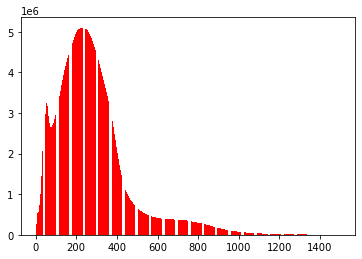

In [ ]:
fig = plt.figure()
plt.bar(hist[1][1:-1],count_r[1:],  color='r')

In [ ]:
mean=0
std=0
maxs=0
for file in tqdm.tqdm(df.name):
    temp= MriTensorImage.create(str(file)).numpy()
    temp=temp[np.nonzero(temp)]
    mean += temp.mean()
    std += temp.std()
#     maxs=temp.max() if temp.max()>maxs else maxs


100%|██████████| 1003/1003 [05:05<00:00,  3.29it/s]


In [ ]:
print(mean/len(df), std/len(df))

0.28778510728659684 0.10024815650725531


In [ ]:
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(MriTensorImage.create)),CategoryBlock),
               get_x=ColReader('name'),
               get_y=ColReader('label'),
               splitter=RandomSplitter(valid_pct=0.2,seed=2),
#                get_y=parent_label,
              )

In [ ]:
ds = db.datasets(source=df)

idx = 20
img = ds.train[idx]
# _, ax = plt.subplots(1, 2, figsize=(10, 5))
# img.show(ctx=ax[0])
# msk.show(ctx=ax[1])

In [ ]:
img[0].shape

(1, 181, 217, 181)

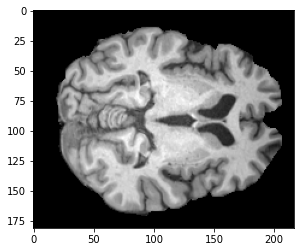

In [ ]:
img[0].show()

In [ ]:
#export 
@typedispatch
def show_batch(x:MriTensorImage, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(MriTensorImage.create)),CategoryBlock),
               get_x=ColReader('name'),
               get_y=ColReader('label'),
               splitter=RandomSplitter(valid_pct=0.2,seed=2),
#                get_y=parent_label,
              )

In [ ]:
dls = db.dataloaders(source=df, bs=4, num_workers=0)
# dls.show_batch??

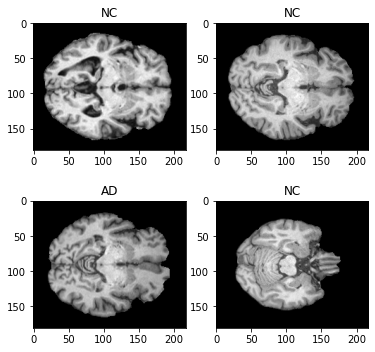

In [ ]:
dls.show_batch()

In [ ]:
aa,bb=first(dls.train)

In [ ]:
aa.min()

MriTensorImage(-2.8800, device='cuda:0')

In [ ]:
#export 
import skimage.transform as skt
# import tqdm

In [ ]:

# def resize(img, new_shape, interpolation=1):
#     """
#     img: [H, W, D, C] or [H, W, D]
#     new_shape: [H, W, D]
#     """
#     return skt.resize(img, new_shape, order=interpolation, mode='constant', cval=0, clip=True, anti_aliasing=False)
# class MRIresize(ItemTransform):
#     def encodes(self, x):
#         img,cate = x
#         newimg=resize(img,(224,224,224))
#         return MriTensorImage(newimg), cate
# # tfm = MRIresize()
# # a,b = tfm(dls.train_ds[0])

In [ ]:
# #export 
# from albumentations.pytorch import ToTensorV2
# import albumentations as A

In [ ]:
# #export 
# aug_pipe = A.Compose([
# #     A.RandomBrightnessContrast(),
# #     A.RandomGamma(gamma_limit=(0.7, 1.0)),
# #     A.GaussNoise(var_limit=(0,0.1),p=0.4),
#     A.Normalize(mean=0.0944,std=0.1783,max_pixel_value=1.0,always_apply=True),ToTensorV2()]
    
# )
# aug_pipe2 = A.Compose([
#     A.Normalize(mean=0.0944,std=0.1783,max_pixel_value=1.0,always_apply=True),ToTensorV2()]
  
# )


# class SegmentationAlbumentationsTransform(ItemTransform):
#     split_idx = 0
#     def __init__(self, aug): self.aug = aug
#     def encodes(self, x):
#         img,mask = x
#         aug = self.aug(image=img.squeeze().numpy())
# #         print(aug['mask'].shape)
#         return MriTensorImage.create(aug['image'].permute(1,2,0).unsqueeze(0)),mask

# class SegmentationAlbumentationsTransform2(ItemTransform):
#     split_idx = 1
#     def __init__(self, aug): self.aug = aug
#     def encodes(self, x):
#         img,mask = x
#         aug = self.aug(image=img.squeeze().numpy())
# #         prin
# #         print(aug['mask'].shape)
#         return MriTensorImage.create(aug['image'].permute(1,2,0).unsqueeze(0)),mask

# # Create our class with this aug_pipe
# # aug = SegmentationAlbumentationsTransform(aug_pipe)
# # aug2 = SegmentationAlbumentationsTransform2(aug_pipe2)


NameError: name 'A' is not defined

In [ ]:
# #export 
# aug = SegmentationAlbumentationsTransform(aug_pipe2)
# aug2 = SegmentationAlbumentationsTransform2(aug_pipe2)

In [ ]:
# db = DataBlock(blocks=(TransformBlock(type_tfms=partial(MriTensorImage.create)),CategoryBlock),
#                get_items=partial(get_files, extensions='.gz'),
#                splitter=RandomSplitter(valid_pct=0.1),
#                get_y=parent_label,
#                item_tfms=[aug,aug2]
# #                item_tfms=[aug,aug2,ToTensor()]
# #                item_tfms=[MRIresize()]
#               )

# # db.summary(source=path)

In [ ]:
dls = db.dataloaders(source=path, bs=4, num_workers=0)

In [ ]:
aa,bb=first(dls.train)

In [ ]:
aa.shape

(4, 1, 181, 217, 181)

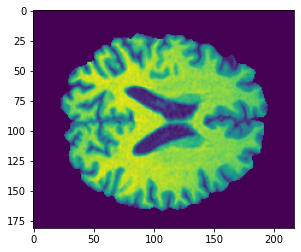

In [ ]:
plt.imshow(aa[3,0,90,:,:].cpu())

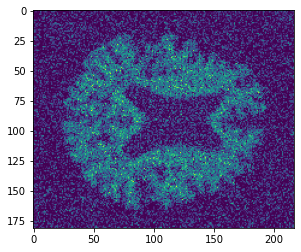

In [ ]:
plt.imshow(aa[3,0,90,:,:].cpu())

In [ ]:
indexs=[]
for temp in tqdm.tqdm(dls.train_ds):
    temp=tfm(temp)
    x = rearrange(temp[0], '(c p1) (h p2) (w p3) ->(c h w) (p1 p2 p3)', p1 = p, p2 = p,p3=p)
    x=x.sum(1)
    x=(x==0).numpy()
    indexs.append(x)
    

100%|██████████| 711/711 [12:27<00:00,  1.05s/it]


In [ ]:
x.shape

(2744,)

In [ ]:
xmax=x.sum(2)

In [ ]:
(xmax.data[0]==0).sum()

tensor(1788, device='cuda:0')

In [ ]:
(xmax.data[1]==0).sum()

tensor(1718, device='cuda:0')

In [ ]:
(xmax.data[2]==0).sum()

tensor(1730, device='cuda:0')

In [ ]:
temp=(xmax.data[2]==0).cpu().numpy().astype('int')

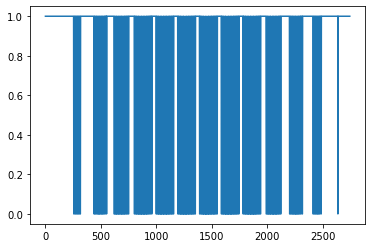

In [ ]:
plt.plot(temp)

In [ ]:
from nbdev.export import notebook2script


In [ ]:
notebook2script(fname='./01_MRI.ipynb')

Converted 01_MRI.ipynb.
